In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from palettable.colorbrewer.qualitative import Dark2_5, Set1_3
import astropy.units as u

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

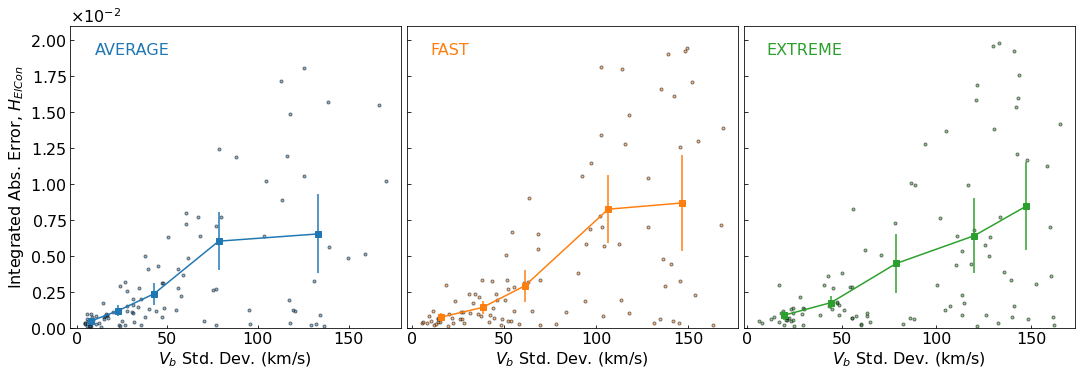

In [2]:
data_path = "C:/Users/yq904481/research/repos/GeoModelUncertainty/data/out_data/CME_scenarios_simulation_results.hdf5"
sim_data = h5py.File(data_path, 'r')

scenario_keys = ['average', 'fast', 'extreme']
colors = [mpl.cm.tab10.colors[i] for i in range(len(scenario_keys))]
scenario_cols = {lab:mpl.cm.tab10.colors[i] for i, lab in enumerate(scenario_keys)}
observer_lons = sim_data['average/run_000/observer_lons'][()]
observer_keys = ["Observer {:3.2f}".format(l) for l in observer_lons]

gk = 'elp'
ok = "Observer 300.00"
scale = 1*u.AU.to(u.km)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, sk in enumerate(scenario_keys):

    scenario = sim_data[sk]

    r_path = "/".join(['cme_apex','r'])
    rg_path = "/".join(['observers', ok, gk, 'r_apex'])
    r_int_limit = 0.5
    sum_err = []
    sum_abs_err = []
    v_std = []
    dv_std = []
    
    for r_key, run in scenario.items():
        
        v_std.append(run['v_b_std'][()])
        dv_std.append(run['dv_b_std'][()])
        
        # Get the HUXt and GM apex distances
        r = run[r_path][()]/scale
        rg = run[rg_path][()]/scale

        # Find only the valid values in each and compute the error and absolute error
        id_good = np.isfinite(r) & np.isfinite(rg)
        r = r[id_good]
        rg = rg[id_good]
        err = rg - r
        abs_err = np.abs(err)

        # Integrate the errors up to r_int_limit, save to array
        id_sub = r <= r_int_limit
        err_intg = np.trapz(err[id_sub], r[id_sub])
        sum_err.append(err_intg)

        abs_err_intg = np.trapz(abs_err[id_sub], r[id_sub])
        sum_abs_err.append(abs_err_intg)

    
    #ax[i].plot(v_std, sum_abs_err, '.', color=scenario_cols[sk])
    
    x = pd.DataFrame(data={'v_std': v_std, 'h': sum_abs_err})
    ax[i].plot(x['v_std'], x['h'], '.', color=scenario_cols[sk], mec='k', alpha=0.5, zorder=1)
    
    # Now group by deciles and compute mean.
    qlabels = [1,2,3,4,5]
    x['v_q'] = pd.qcut(x['v_std'], len(qlabels), labels=qlabels)
    x_avg = x.groupby('v_q').mean()
    x_sem = 2*x.groupby('v_q').sem()
    
    ax[i].errorbar(x_avg['v_std'], x_avg['h'], yerr=x_sem['h'], fmt='s-', color=scenario_cols[sk], zorder=2)
    
sim_data.close()

# Get formatter for scientific notation on y-axis
formatter = mpl.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

# Format the axes
for a in ax:
    a.set_ylim(0, 0.021)
    a.tick_params(direction='in')
    a.set_xlabel('$V_{b}$ Std. Dev. (km/s)')
    a.yaxis.set_major_formatter(formatter)
    
for a in ax[1:]:
    a.set_yticklabels([])
    
ax[0].set_ylabel('Integrated Abs. Error, $H_{ElCon}$')

# Add on labels for the scenario
for a, sk in zip(ax, scenario_keys):
    a.text(10, 1.9e-2, sk.upper(), color=scenario_cols[sk], fontsize=16)
    
fig.subplots_adjust(left=0.06, bottom=0.11, right=0.99, top=0.95, wspace=0.02)

project_dirs = gmu.get_project_dirs()
fig_name = 'v_bound_std_vs_H.pdf'
fig_path = os.path.join(project_dirs['paper_figures'], fig_name)
fig.savefig(fig_path)

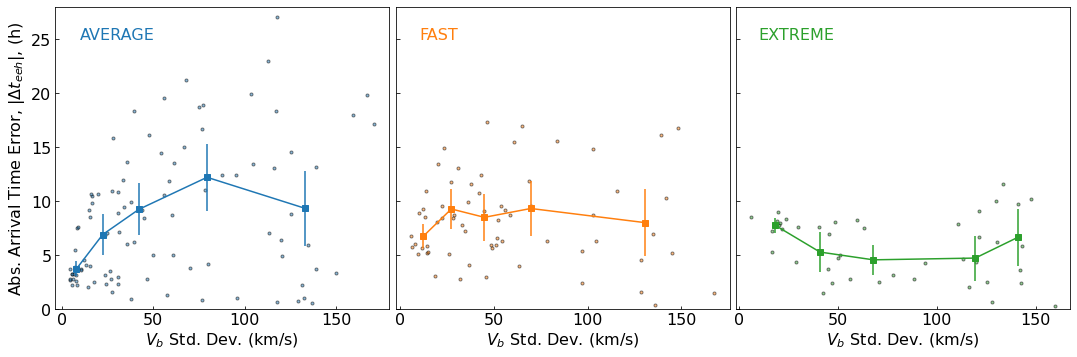

In [4]:
data_path = "C:/Users/yq904481/research/repos/GeoModelUncertainty/data/out_data/CME_scenarios_simulation_results.hdf5"
sim_data = h5py.File(data_path, 'r')

project_dirs = gmu.get_project_dirs()

scenario_keys = ['average', 'fast', 'extreme']
colors = [mpl.cm.tab10.colors[i] for i in range(len(scenario_keys))]
scenario_cols = {lab:mpl.cm.tab10.colors[i] for i, lab in enumerate(scenario_keys)}
observer_lons = sim_data['average/run_000/observer_lons'][()]
observer_keys = ["Observer {:3.2f}".format(l) for l in observer_lons]

gk = 'elp'
ok = "Observer 300.00"
scale = 1*u.AU.to(u.km)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, scenario in enumerate(scenario_keys):
    
    elevo_key = 'ELEvoHI_' + scenario
    elevo = pd.read_csv(project_dirs[elevo_key], delim_whitespace=True)
    
    elevo['v_b_std'] = 0
    elevo['v_std'] = 0
    elevo['dv_b_std'] = 0
    elevo['dv_std'] = 0
    
    for j, row in elevo.iterrows():
        
        sim_path = "/".join([scenario, row['run'], 'v_b_std'])
        elevo.loc[j, 'v_b_std'] = sim_data[sim_path][()]
        
        sim_path = "/".join([scenario, row['run'], 'v_std'])
        elevo.loc[j, 'v_std'] = sim_data[sim_path][()]
        
        sim_path = "/".join([scenario, row['run'], 'dv_b_std'])
        elevo.loc[j, 'dv_b_std'] = sim_data[sim_path][()]
        
        sim_path = "/".join([scenario, row['run'], 'dv_std'])
        elevo.loc[j, 'dv_std'] = sim_data[sim_path][()]
        
    # Now plot error vs v_boundary var for L5.
    id_l5 = elevo['sep'] == 300
    x = elevo.loc[id_l5, 'v_b_std']
    y = elevo.loc[id_l5, 'mae_t']
    data = elevo.loc[id_l5, ['v_b_std', 'mae_t']]
    data.set_index(np.arange(0,data.shape[0]), inplace=True)
    
    ax[i].plot(x, y, '.', color=scenario_cols[scenario], mec='k', alpha=0.5, zorder=1)
    
    # Now group by deciles and compute mean.
    qlabels = [1,2,3,4,5]
    data['v_b_q'] = pd.qcut(data['v_b_std'], len(qlabels), labels=qlabels)
    data_avg = data.groupby('v_b_q').mean()
    data_sem = 2*data.groupby('v_b_q').sem()
    
    ax[i].errorbar(data_avg['v_b_std'], data_avg['mae_t'], yerr=data_sem['mae_t'], fmt='s-', color=scenario_cols[scenario], zorder=2)
    
    
sim_data.close()        


fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=0.99, wspace=0.1)
    
for a in ax:
    a.set_ylim(0, 28)
    a.tick_params(direction='in')
    a.set_xlabel('$V_{b}$ Std. Dev. (km/s)')
    
for a in ax[1:]:
    a.set_yticklabels([])
    
ax[0].set_ylabel('Abs. Arrival Time Error, $|\\Delta t_{eeh}|$, (h)')

# Add on labels for the scenario
for a, sk in zip(ax, scenario_keys):
    a.text(10, 25, sk.upper(), color=scenario_cols[sk], fontsize=16)
    
fig.subplots_adjust(left=0.05, bottom=0.11, right=0.99, top=0.95, wspace=0.02)

project_dirs = gmu.get_project_dirs()
fig_name = 'v_bound_std_vs_elevo_dt.pdf'
fig_path = os.path.join(project_dirs['paper_figures'], fig_name)
fig.savefig(fig_path)